# Analytics

This notebook analyzes poker hand logs with improved code organization.

## Architecture
- `poker_utils.py`: Utility functions (card parsing, position detection)
- `poker_data.py`: Data loading and hand parsing
- `poker_stats.py`: Statistical analysis calculations
- `poker_advanced_stats.py`: Advanced statistics (VPIP, PFR, 3bet%, cbet%, etc.)
- `poker_viz.py`: Visualization and reporting

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

# Import custom modules
import poker_data
import poker_stats
import poker_viz
import poker_utils

# Reload modules to pick up any changes
importlib.reload(poker_utils)
importlib.reload(poker_data)
importlib.reload(poker_stats)
importlib.reload(poker_viz)

from poker_data import PokerDataLoader, HandParser, PlayerMapper
from poker_stats import PlayerStatistics, AllInAnalyzer, RangeAnalyzer
from poker_viz import RangeVisualizer, StatisticsReporter
from poker_utils import parse_player_string

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("✓ Modules loaded and reloaded successfully")

✓ Modules loaded and reloaded successfully


In [34]:
# ============================================================================
# ANALYSIS CONFIGURATION - Edit these variables to customize your analysis
# ============================================================================
PLAYER = "jho"

# Player to analyze for positional stats (Section 6)
# Options: Any player name, or None for most active player
POSITIONAL_PLAYER = PLAYER  # Set to None to auto-select most active player

# Player to analyze for all-in EV (Section 5)
# Options: Any player name, or None to show all players
ALLIN_PLAYER = PLAYER  # Set to None to show all players

# Player to generate range chart for (Section 7)
# Options: Any player name from the available players
RANGE_CHART_PLAYER = PLAYER

print("✓ Configuration loaded")
print(f"  • Player: {PLAYER}")


✓ Configuration loaded
  • Player: jho


## 1. Load Data

In [25]:
# Initialize data loader
loader = PokerDataLoader(data_dir='data/log', ledger_dir='data/ledger')

# Load log data
raw_data = loader.load_log_data()
raw_data.head(10)

Loading 0101_logdata.csv...
Loading 0103_logdata.csv...
Loading 0105_logdata.csv...
Loading 1230_logdata.csv...
Loading 1231_logdata.csv...

Total entries: 75,936
Date range: 2025-12-30 09:46:25.557000+00:00 to 2026-01-05 16:15:11.315000+00:00



,entry,at,order,source_file
0,"""jho @ t3NhL8TnYz"" checks",2025-12-30 09:46:25.557000+00:00,176708798555700,1230_logdata.csv
1,"""LIT2 @ Mw0SATaN53"" bets 6000",2025-12-30 09:46:27.945000+00:00,176708798794500,1230_logdata.csv
2,"""zxc @ uaMcxyz0Rj"" calls 6000",2025-12-30 09:46:29.851000+00:00,176708798985100,1230_logdata.csv
3,"""jho @ t3NhL8TnYz"" calls 6000",2025-12-30 09:46:36.922000+00:00,176708799692200,1230_logdata.csv
4,"Turn: 6♣, 8♥, 5♣ [8♣]",2025-12-30 09:46:37.728000+00:00,176708799772800,1230_logdata.csv
5,"""zxc @ uaMcxyz0Rj"" checks",2025-12-30 09:46:39.109000+00:00,176708799910900,1230_logdata.csv
6,"""jho @ t3NhL8TnYz"" checks",2025-12-30 09:46:42.547000+00:00,176708800254700,1230_logdata.csv
7,"""LIT2 @ Mw0SATaN53"" checks",2025-12-30 09:46:43.635000+00:00,176708800363500,1230_logdata.csv
8,"River: 6♣, 8♥, 5♣, 8♣ [2♣]",2025-12-30 09:46:44.460000+00:00,176708800446000,1230_logdata.csv
9,"""zxc @ uaMcxyz0Rj"" checks",2025-12-30 09:46:46.893000+00:00,176708800689300,1230_logdata.csv


## 2. Parse Hands

In [26]:
# Parse all hands from log data
hands = HandParser.parse_hands(raw_data)
print(f"✓ Parsed {len(hands):,} complete poker hands")

✓ Parsed 4,148 complete poker hands


## 3. Player Identity Mapping

Edit the dictionary below to merge multiple player IDs into unified names.

In [27]:
# Get all unique player IDs
all_player_ids = set()
for hand in hands:
    all_player_ids.update(hand['players'].keys())

# Display unique players
print("📋 ALL UNIQUE PLAYER IDs FOUND:")
print("="*80)
print(f"{'ID':<20} | Username")
print("-"*80)

initial_mapping = {}
for player_str in sorted(all_player_ids):
    player_id, username = parse_player_string(player_str)
    initial_mapping[player_id] = username
    print(f"{player_id:<20} | {username}")

print("\n✏️  EDIT THE DICTIONARY BELOW to merge multiple IDs:")

📋 ALL UNIQUE PLAYER IDs FOUND:
ID                   | Username
--------------------------------------------------------------------------------
xswHkyUXqL           | 9292
Ek559oOV8c           | 9917
Ek559oOV8c           | 9917.
xpbZinNQx9           | 9917..
eLlYR19TDN           | Black
g0FfVCh6gI           | Justin
Mw0SATaN53           | LIT
thyyJUIpI9           | LIT
3jIWLYiXzx           | LIT2
Mw0SATaN53           | LIT2
xswHkyUXqL           | O9O9
xswHkyUXqL           | Z9Z9
xswHkyUXqL           | Z9z9
e2LT3dd3Tx           | black
t3NhL8TnYz           | jho
u341hEhZ9E           | zxc
uaMcxyz0Rj           | zxc
cIaXP7lyE_           | zxc2
u341hEhZ9E           | zxc2
eLlYR19TDN           | 블몬

✏️  EDIT THE DICTIONARY BELOW to merge multiple IDs:


In [28]:
# EDITABLE PLAYER MAPPING
# Map all player IDs to unified player names

player_id_mapping = {
    # LIT (sometimes appears as LIT or LIT2)
    "3jIWLYiXzx": "LIT",
    "thyyJUIpI9": "LIT",
    "Mw0SATaN53": "LIT",

    # zxc (including zxc2)
    "u341hEhZ9E": "zxc",
    "uaMcxyz0Rj": "zxc",
    "cIaXP7lyE_": "zxc",
    "HwYscE0DK2": "zxc",

    # black (including BM and 블몬)
    "e2LT3dd3Tx": "black",
    "eLlYR19TDN": "black",
    "6HmBRHGZcY": "black",
    "P2jS_dvDyj": "black",
    "LEYWZ_6-T9": "black",

    # sh
    "xpbZinNQx9": "sh",
    "Ek559oOV8c": "sh",
    "q21UtMebOx": "sh",

    # 9292 (including 92929)
    "xswHkyUXqL": "9292",
    "f_ZuasHCJZ": "9292",
    "exrnYGgrmM": "9292",

    # jho
    "t3NhL8TnYz": "jho",

    # Justin
    "g0FfVCh6gI": "Justin",
    "uhEB5tfxOo": "Justin",
}

# Add any missing IDs with their default usernames
for player_id, username in initial_mapping.items():
    if player_id not in player_id_mapping:
        player_id_mapping[player_id] = username

# Initialize player mapper
player_mapper = PlayerMapper(player_id_mapping)
player_mapper.build_mapping(all_player_ids)

print(f"✓ Player mapping loaded with {len(player_id_mapping)} ID entries")

# Show merged accounts
merged = player_mapper.get_merged_accounts()
if merged:
    print(f"\n🔗 MERGED ACCOUNTS (multiple IDs → same username):")
    for username, ids in merged.items():
        print(f"   {username}: {', '.join(ids)}")

✓ Player mapping loaded with 21 ID entries

🔗 MERGED ACCOUNTS (multiple IDs → same username):
   LIT: 3jIWLYiXzx, thyyJUIpI9, Mw0SATaN53
   zxc: u341hEhZ9E, uaMcxyz0Rj, cIaXP7lyE_, HwYscE0DK2
   black: e2LT3dd3Tx, eLlYR19TDN, 6HmBRHGZcY, P2jS_dvDyj, LEYWZ_6-T9
   sh: xpbZinNQx9, Ek559oOV8c, q21UtMebOx
   9292: xswHkyUXqL, f_ZuasHCJZ, exrnYGgrmM
   Justin: g0FfVCh6gI, uhEB5tfxOo


## 4. Player Statistics

In [29]:
# Load ledger data and map player names
ledger_data = loader.load_ledger_data()
ledger_data = player_mapper.map_ledger_data(ledger_data)

# Calculate player statistics
stats_calculator = PlayerStatistics(player_mapper)
player_stats = stats_calculator.calculate_from_sessions(ledger_data)

# Display results
StatisticsReporter.print_player_summary(player_stats)

Loading 0101_ledger.csv...
Loading 0103_ledger.csv...
Loading 0105_ledger.csv...
Loading 1216_ledger.csv...
Loading 1217.1_ledger.csv...
Loading 1217.2_ledger.csv...
Loading 1218_ledger.csv...
Loading 1221_ledger.csv...
Loading 1222_ledger.csv...
Loading 1224_ledger.csv...
Loading 1226_ledger.csv...
Loading 1227_ledger.csv...
Loading 1228_ledger.csv...
Loading 1229_ledger.csv...
Loading 1230_ledger.csv...
Loading 1231_ledger.csv...
Total ledger entries: 308

PLAYER PERFORMANCE SUMMARY

Player       Net Profit Sessions   Wins Losses    Win%  Biggest Win  Biggest Loss
--------------------------------------------------------------------------------
jho           4,068,662       15     11      4   73.3%    2,061,944    -1,300,000
LIT           2,578,197       15      9      6   60.0%      950,000      -600,200
zxc           2,472,513       16     11      5   68.8%    1,165,150      -671,250
black           137,068       15      8      7   53.3%    1,383,350      -894,962
Justin       -1,41

## 4.5 Advanced Player Statistics

Calculate comprehensive playing style statistics for each player organized by street:

**Preflop**: VPIP, PFR, 3bet%, 4bet%, Call vs 3bet%

**Flop**: Cbet%, Fold to Cbet%, Cbet after 3bet%, Check after 3bet%

**Turn**: Turn Cbet% (Double Barrel), Fold to Turn Cbet%

**Miscellaneous**: Donk Bet%, Bet when Checked To% (as not the Preflop Raiser), Check Raise%, WTSD%

**Note**: Heads-up hands (only 2 players) are excluded from this analysis to provide more accurate multi-way statistics.

In [30]:
# Import advanced statistics module
from poker_advanced_stats import DetailedHandAnalyzer

# Parse hands with detailed action tracking
print("Parsing hands with detailed action tracking...")
detailed_analyzer = DetailedHandAnalyzer(player_mapper)
detailed_hands = detailed_analyzer.parse_hands_with_actions(raw_data)

print(f"✓ Parsed {len(detailed_hands):,} hands with action tracking")

# Calculate advanced statistics
print("\nCalculating advanced statistics...")
advanced_stats = detailed_analyzer.calculate_advanced_stats(detailed_hands)

print("\n" + "="*100)
print("ADVANCED PLAYER STATISTICS")
print("="*100)

if len(advanced_stats) > 0:
    # Display PREFLOP statistics
    print("\n📊 PREFLOP STATISTICS")
    print("-"*100)
    preflop_df = advanced_stats[['hands', 'vpip', 'pfr', 'threebets', 'fourbets', 'call_vs_3bet']].copy()
    preflop_df.columns = ['Hands', 'VPIP%', 'PFR%', '3bet%', '4bet%', 'Call vs 3bet%']
    print(preflop_df.to_string())
    
    # Display FLOP statistics
    print("\n\n🃏 FLOP STATISTICS")
    print("-"*100)
    flop_df = advanced_stats[['flop_hands', 'cbet', 'fold_to_cbet', 'cbet_after_3bet', 'check_after_3bet']].copy()
    flop_df.columns = ['Flop Hands', 'Cbet%', 'Fold to Cbet%', 'Cbet after 3bet%', 'Check after 3bet%']
    print(flop_df.to_string())
    
    # Display TURN statistics
    print("\n\n🔄 TURN STATISTICS")
    print("-"*100)
    turn_df = advanced_stats[['turn_hands', 'turn_cbet', 'fold_to_turn_cbet']].copy()
    turn_df.columns = ['Turn Hands', 'Turn Cbet%', 'Fold to Turn Cbet%']
    print(turn_df.to_string())
    
    # Display miscellaneous statistics
    print("\n\n🎯 MISC STATISTICS")
    print("-"*100)
    misc_df = advanced_stats[['donk_bet', 'bet_when_checked_to', 'check_raise', 'wtsd']].copy()
    misc_df.columns = ['Donk Bet%', 'Bet when Checked To%', 'Check Raise%', 'WTSD%']
    print(misc_df.to_string())

else:
    print("No statistics available.")

print("="*100)

Parsing hands with detailed action tracking...
✓ Parsed 4,148 hands with action tracking

Calculating advanced statistics...
   Excluded 701 heads-up hands (only 2 players)
   Analyzing 3,447 hands with 3+ players

ADVANCED PLAYER STATISTICS

📊 PREFLOP STATISTICS
----------------------------------------------------------------------------------------------------
        Hands  VPIP%  PFR%  3bet%  4bet%  Call vs 3bet%
player                                                 
9292     2634   65.4  22.2    8.9    4.9           89.3
black    2333   59.0  21.9    5.0    8.7           85.2
LIT      2139   53.8   7.7    4.5    8.3           86.7
Justin   2019   51.6  28.0    8.2    6.9           84.0
zxc      1966   40.1  16.9    4.3    7.4           71.6
jho      1824   46.3  22.1    6.9    8.2           79.1
sh        727   65.5   7.8    4.3    4.5           95.5


🃏 FLOP STATISTICS
----------------------------------------------------------------------------------------------------
        Fl

## 5. Positional Analysis

In [31]:
# Calculate positional statistics
positional_stats = stats_calculator.calculate_positional_stats(hands)

# Determine which player to display
if POSITIONAL_PLAYER and POSITIONAL_PLAYER in positional_stats:
    selected_player = POSITIONAL_PLAYER
else:
    # Use most active player if not specified or not found
    selected_player = player_stats.index[0]  # Top player by net profit
    if POSITIONAL_PLAYER:
        print(f"⚠️  Player '{POSITIONAL_PLAYER}' not found. Using top player instead.\n")

StatisticsReporter.print_positional_analysis(positional_stats, selected_player)

print(f"\n✓ Positional data calculated for all {len(positional_stats)} players")


🎯 POSITIONAL ANALYSIS

Positional Stats for Justin:
--------------------------------------------------------------------------------
Position  Hands  Win Rate %  Invested     Won      Net
     BTN    648        32.1   6656737 5320928 -1335809
      BB    645        41.9   7562580 7969088   406508
      SB    501        27.3   5529487 6204246   674759
     UTG    343        21.0   4574582 4804606   230024
      CO    138        18.8   1434715  889000  -545715
      HJ     36        13.9    212750   93600  -119150
   UTG+1      4         0.0         0       0        0

💡 POSITIONAL INSIGHTS for Justin:
   • Most Profitable Position: SB (Net: $674,759)
   • Least Profitable Position: BTN (Net: $-1,335,809)

✓ Positional data calculated for all 7 players


## 6. Hand Range Analysis

Displays a range chart for the player configured in the Configuration section.

✓ Range data calculated for 7 players with showdown data

Players with showdown data:
   • 9292: 393 showdowns
   • Justin: 285 showdowns
   • LIT: 273 showdowns
   • black: 346 showdowns
   • jho: 159 showdowns
   • sh: 122 showdowns
   • zxc: 169 showdowns

Generating range chart for: jho


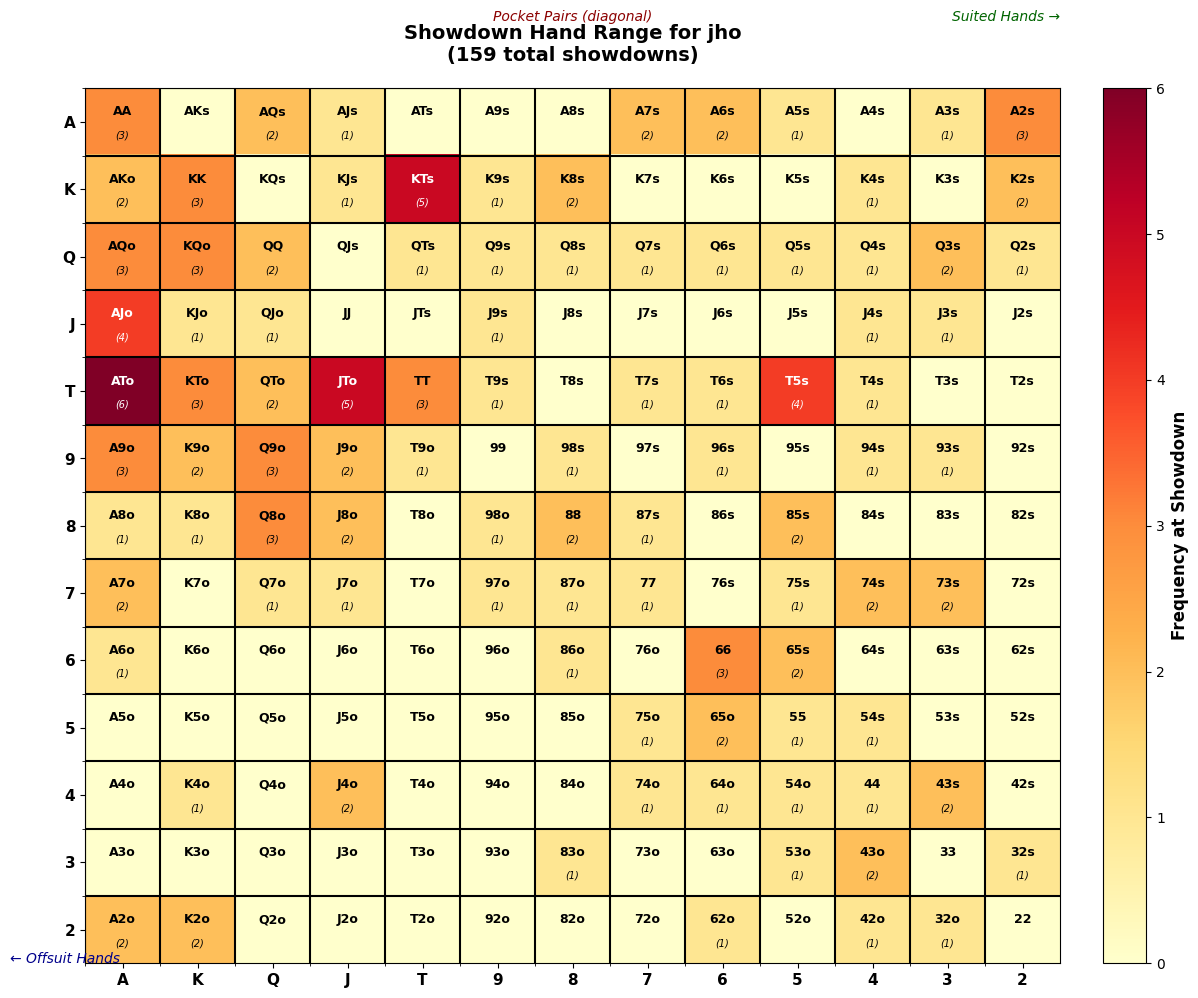

In [35]:
# Calculate hand ranges and create matrix
range_analyzer = RangeAnalyzer(player_mapper)
player_ranges = range_analyzer.collect_showdown_ranges(hands)
hand_matrix, ranks = RangeAnalyzer.create_hand_matrix()

print(f"✓ Range data calculated for {len(player_ranges)} players with showdown data")
print(f"\nPlayers with showdown data:")
for player in sorted(player_ranges.keys()):
    showdown_count = sum(player_ranges[player].values())
    print(f"   • {player}: {showdown_count} showdowns")

# Generate hand range heatmap for configured player
if RANGE_CHART_PLAYER in player_ranges:
    print(f"\nGenerating range chart for: {RANGE_CHART_PLAYER}")
    freq_matrix = RangeVisualizer.plot_hand_range_heatmap(
        RANGE_CHART_PLAYER,
        player_ranges[RANGE_CHART_PLAYER],
        hand_matrix,
        ranks
    )
else:
    print(f"\n⚠️  Player '{RANGE_CHART_PLAYER}' not found or has no showdown data.")
    print(f"\nAvailable players with showdown data:")
    for player in sorted(player_ranges.keys()):
        print(f"   • {player}")

## 7. Hand Profit/Loss Analysis

Displays a profit/loss heatmap for starting hands, showing which hands have been most and least profitable.

✓ Hand profit data calculated for 7 players

Top 10 Most Profitable Hands for Justin:
------------------------------------------------------------
  AKs : $   691,550
  AA  : $   598,050
  QQ  : $   333,338
  88  : $   331,550
  JJ  : $   305,600
  KJo : $   300,975
  J9o : $   234,900
  K8s : $   229,400
  55  : $   199,350
  A6o : $   190,750

Top 10 Least Profitable (Most Losing) Hands for Justin:
------------------------------------------------------------
  A2o : $  -105,600
  98s : $  -105,900
  74s : $  -113,800
  54o : $  -128,700
  T6s : $  -142,649
  Q7s : $  -151,900
  96s : $  -181,825
  K5s : $  -198,400
  AQs : $  -257,304
  QJo : $  -370,821

Generating profit/loss heatmap for: Justin


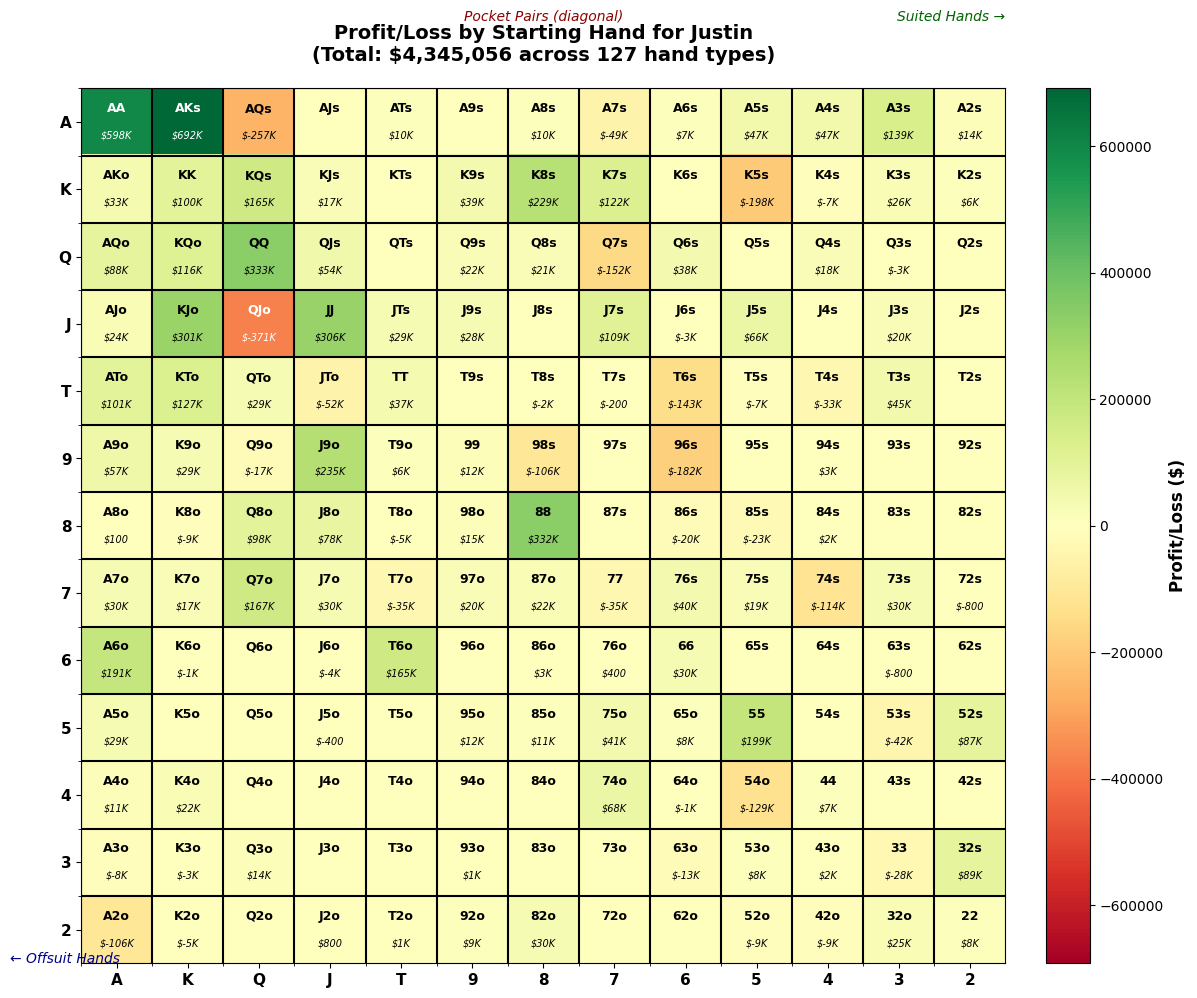

In [33]:
# Calculate hand profits for all players
hand_profits = range_analyzer.collect_hand_profits(hands)
hand_matrix, ranks = RangeAnalyzer.create_hand_matrix()

print(f"✓ Hand profit data calculated for {len(hand_profits)} players\n")

# Display summary of most profitable/unprofitable hands
if RANGE_CHART_PLAYER in hand_profits:
    player_profits = hand_profits[RANGE_CHART_PLAYER]
    
    # Sort hands by profit
    sorted_hands = sorted(player_profits.items(), key=lambda x: x[1], reverse=True)
    
    print(f"Top 10 Most Profitable Hands for {RANGE_CHART_PLAYER}:")
    print("-" * 60)
    for hand, profit in sorted_hands[:10]:
        print(f"  {hand:4s}: ${profit:>10,.0f}")
    
    print(f"\nTop 10 Least Profitable (Most Losing) Hands for {RANGE_CHART_PLAYER}:")
    print("-" * 60)
    for hand, profit in sorted_hands[-10:]:
        print(f"  {hand:4s}: ${profit:>10,.0f}")
    
    # Generate profit/loss heatmap
    print(f"\nGenerating profit/loss heatmap for: {RANGE_CHART_PLAYER}")
    profit_matrix = RangeVisualizer.plot_hand_profit_heatmap(
        RANGE_CHART_PLAYER,
        player_profits,
        hand_matrix,
        ranks
    )
else:
    print(f"\n⚠️  Player '{RANGE_CHART_PLAYER}' not found or has no hand data.")
    print(f"\nAvailable players with hand data:")
    for player in sorted(hand_profits.keys()):
        print(f"   • {player}")